# Chapter 1: GemPy Basic

In this first example, we will show how to construct a first basic model and the main objects and functions. First we import gempy:

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


All data get stored in a python object InputData.  This object can be easily stored in a Python pickle. However, these files have the limitation that all dependecies must have the same versions as those when the pickle were created. For these reason to have more stable tutorials we will generate the InputData from raw data---i.e. csv files exported from Geomodeller.

These csv files can be found in the input_data folder in the root folder of GemPy. These tables contains uniquely the XYZ (and poles, azimuth and polarity in the foliation case) as well as their respective formation name (but not necessary the formation order).


In [64]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 60,60,60],
                         path_f = os.pardir+"/input_data/FabLessPoints_Foliations.csv",
                         path_i = os.pardir+"/input_data/FabLessPoints_Points.csv")

../../gempy/data_management.py:61: UserWarning: path_f is deprecated use instead path_o
  warnings.warn('path_f is deprecated use instead path_o')


In [65]:
import pandas as pn
gp.set_orientations(geo_data,pn.DataFrame(geo_data.orientations.iloc[0,:]).T, append=True)
geo_data.orientations.set_value(2, 'formation', 'Overlying')

/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,X_std,Y_std,Z_std,dip_std,azimuth_std,order_series,isFault,formation number,annotations
0,1450,1000,-1150,0.316229,1.000000e-07,0.948683,18.435,90,1,Reservoir,Default serie,NaN,NaN,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$"
2,1450,1000,-1150,0.316229,1.000000e-07,0.948683,18.435,90,1,Overlying,Default serie,NaN,NaN,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},1}$"
1,917.45,1000,-1135.4,-0.948683,1.000000e-07,0.316229,71.565,270,1,MainFault,Default serie,NaN,NaN,NaN,NaN,NaN,1,False,3,"${\bf{x}}_{\beta \,{\bf{3}},0}$"


In [70]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest": ('SecondaryReservoir','Seal', 'Reservoir'), 
                               "Rist": ('Overlying')},
                       order_series = ["fault", 'Rest', 'Rist'],
                       order_formations=['MainFault', 
                                         'SecondaryReservoir', 'Seal','Reservoir', 'Overlying',
                                         ]) 

geo_data =gp.select_series(geo_data,['Rest', 'Rist'])

In [72]:
geo_data.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,X_std,Y_std,Z_std,dip_std,azimuth_std,order_series,isFault,formation number,annotations
0,1450,1000,-1150,0.316229,1.000000e-07,0.948683,18.435,90,1,Reservoir,Rest,NaN,NaN,NaN,NaN,NaN,2,False,3,"${\bf{x}}_{\beta \,{\bf{3}},0}$"
1,1450,1000,-1150,0.316229,1.000000e-07,0.948683,18.435,90,1,Overlying,Rist,NaN,NaN,NaN,NaN,NaN,3,False,4,"${\bf{x}}_{\beta \,{\bf{4}},0}$"


<IPython.core.display.Javascript object>


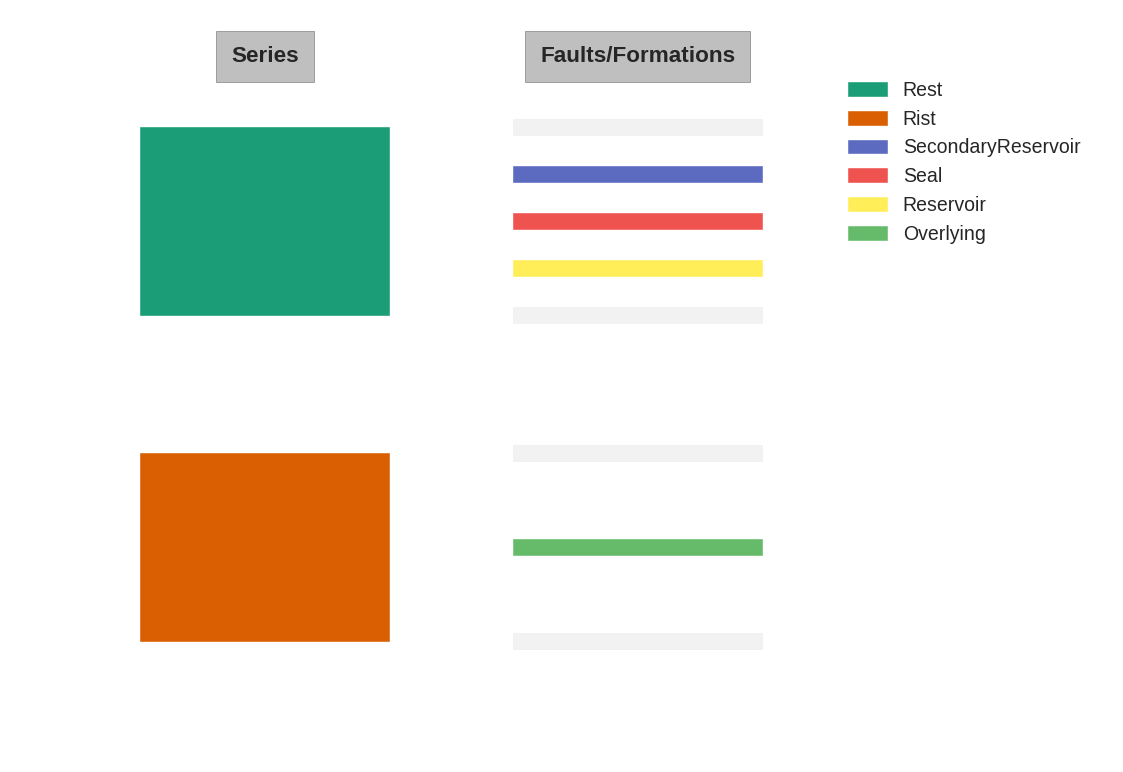

In [73]:
gp.get_sequential_pile(geo_data)

## The ins and outs of Input data objects

As we have seen objects DataManagement.InputData (usually called geo_data in the tutorials) aim to have all the original geological properties, measurements and geological relations stored. 

Once we have the data ready to generate a model, we will need to create the next object type towards the final geological model:

In [74]:
import theano.tensor as T
import theano
interp_data = gp.InterpolatorData(geo_data, u_grade=[1,],
                                  output='geology', dtype='float64',
                                   verbose=['scalar_field_iter', 'block_series', 'yet_simulated'],
                                  compile_theano=False)


In [69]:
%debug

> /home/miguel/PycharmProjects/gempy/gempy/interpolator.py(464)data_prep()
    462             # Cumulative length of the series. We add the 0 at the beginning and set the shared value. SHARED
    463 
--> 464             assert len_series_f.shape[0] is len_series_i.shape[0], 'You need at least one orientation per series'
    465             self.tg.len_series_f.set_value(np.insert(len_series_f, 0, 0).cumsum().astype('int32'))
    466 

ipdb> exit


In [ ]:
interp_data.interpolator.tg.len_series_i.get_value()

In [ ]:
#interp_data.interpolator.tg.n_formation_float.set_value(np.array([ 1.,  2.,  3.,  4.,  5., 6.], dtype='float32'))

In [52]:
#interp_data.interpolator.tg.n_formations_per_serie.set_value(np.array([0, 1, 6], dtype='int32'))

In [53]:
#interp_data.interpolator.tg.npf.get_value()

In [43]:
geo_data.interfaces.shape

(34, 12)

In [44]:
interp_data.interpolator.tg.npf.get_value()[1:7]

array([ 5, 10, 23, 30], dtype=int32)

In [82]:
import matplotlib.pyplot as plt
x = np.linspace(-10,50)
sigm = 1. / (1 + np.exp(-1 * (x - 0))) + 1. / (1 + np.exp(1 * (x - 30))) -1
plt.plot(x, sigm)

In [75]:
sol = gp.compute_model(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
scalar_field_at_form __str__ = [ 0.  0.  0.  0.]
yet_simulated __str__ = [     0      1      2 ..., 216057 216058 216059]
yet1 __str__ = [     0      1      2 ..., 216057 216058 216059]


../../gempy/interpolator.py:481: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1
  n_universal_eq[u_grade == 0] = 0
../../gempy/interpolator.py:482: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1
  n_universal_eq[u_grade == 1] = 3
../../gempy/interpolator.py:483: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1
  n_universal_eq[u_grade == 2] = 9


scalar_field_at_form __str__ = [ 0.  0.  0.  0.]
yet_simulated __str__ = [     0      1      2 ..., 216057 216058 216059]
yet1 __str__ = [     0      1      2 ..., 216057 216058 216059]
scalar_field_iter __str__ = [ 40.08137894  40.07036209  39.99600601]
middle point __str__ = [  1.04062675e-27   1.68282674e-27   2.64964049e-27 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
middle point __str__ = [  6.33651197e-23   1.02469529e-22   1.61340079e-22 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
middle point __str__ = [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00885217e-35
   1.00885217e-35   1.00885217e-35]
The chunk of block model of a specific series __str__ = [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00885217e-35
   1.00885217e-35   1.00885217e-35]
scalar_field_at_form __str__ = [ 40.08137894  40.07036209  39.99600601   0.        ]
yet_simulated __str__ = [   480    540    541 ..., 216057 216058 216059]
yet1 __str__ = [   480

<IPython.core.display.Javascript object>


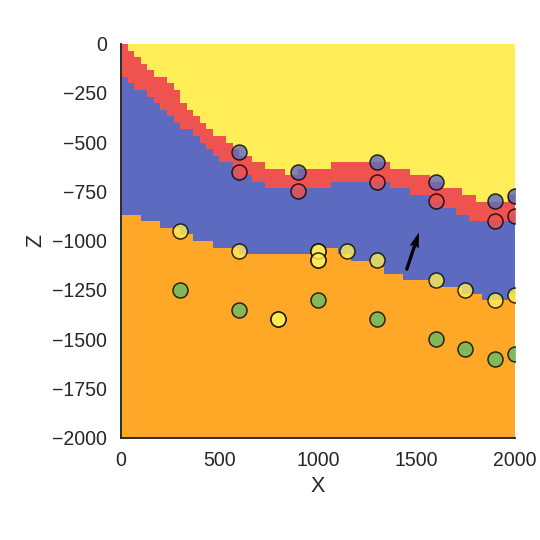

[[  1.84051123e-36   3.96383794e-37   8.63502198e-38 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.47172659e-37   7.87957189e-38   1.81587752e-38 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.24528031e-38   1.74458114e-38   4.27348668e-39 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  2.00565171e+00   2.04051948e+00   2.19714546e+00 ...,   3.00000000e+00
    3.00000000e+00   3.00000000e+00]
 [  2.06711006e+00   2.26975584e+00   2.66436195e+00 ...,   3.00000000e+00
    3.00000000e+00   3.00000000e+00]
 [  2.37578654e+00   2.74204826e+00   2.93501782e+00 ...,   3.00000000e+00
    3.00000000e+00   3.00000000e+00]] <class 'numpy.ndarray'>


In [84]:
%matplotlib notebook
gp.plot_section(geo_data,sol[0][0].astype(float), 30, plot_data = True, direction='y')

<IPython.core.display.Javascript object>


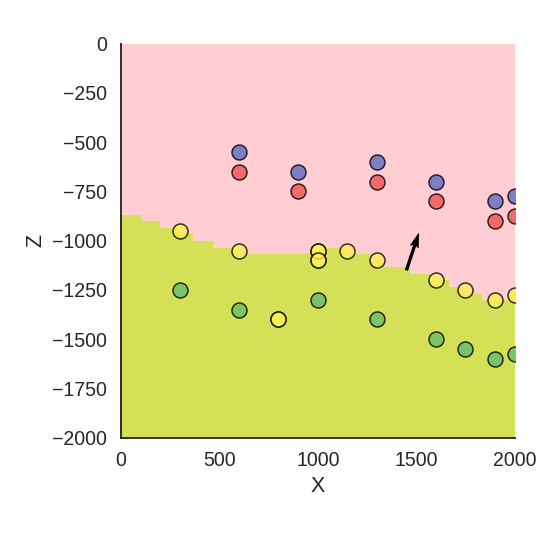

[[  9.91724873   9.91571331   9.91418934 ...,   9.8838377    9.88390636
    9.88380146]
 [  9.91558075   9.91409779   9.91263008 ...,   9.8848505    9.88489437
    9.88474274]
 [  9.91401386   9.91259003   9.91118336 ...,   9.88617992   9.88619232
    9.88598442]
 ..., 
 [ 40.07652664  40.07822418  40.07997513 ...,  40.11064529  40.10971451
   40.10864639]
 [ 40.07875061  40.0803833   40.08206177 ...,  40.11043167  40.109478
   40.10839081]
 [ 40.08087158  40.08243561  40.08404541 ...,  40.11011124  40.10913086
   40.10802841]] <class 'numpy.ndarray'>


In [83]:
gp.plot_section(geo_data, sol[0][1].astype(float), 30, plot_data = True)

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(10,9.83)
sigm = 1. / (1 + np.exp(-1 * (x - 0))) 
plt.plot(x, sigm)

In [ ]:
interp_data.interpolator.tg.n_formation_float.set_value(np.array([ 1.,  2.,  3.,  4.,  5., 6.], dtype='float32'))

In [ ]:
interp_data.interpolator.tg.n_formations_per_serie.get_value()

In [ ]:
gssg


In [ ]:
import theano.tensor
theano.tensor.l

In [ ]:
input_data_T = the.input_parameters_list()
input_data_T

In [ ]:
th_fn = theano.function(input_data_T,
                         the.compute_grad(1),
                                    on_unused_input='ignore',
                                    allow_input_downcast=False,
                                    profile=False)

In [ ]:
i = interp_data.get_input_data()

In [ ]:
interp_data.interpolator.pandas_rest_layer_points.head()

In [ ]:
th_fn(*i)

In [ ]:
lith_block, fault_block = gp.compute_model(interp_data)

In [ ]:
lith_block[0][(lith_block[0] > 1 ) * (lith_block[0] < 2)]

In [ ]:
lith_block[0] < 2

In [ ]:
np.unique(lith_block[0])

In [ ]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], 10, plot_data=True)

In [ ]:
the.input_parameters_list()

In [ ]:
# cov_jac = T.jacobian(T.flatten(the.block_series()),
#                      the.input_parameters_list()[-1])

In [ ]:
gp.set_geophysics_obj(interp_data,  [800,1200,800,1200,-800, -1200],
                                             [5,5])

In [ ]:
a,b = gp.precomputations_gravity(interp_data, 24, [2.92, 3.1, 2.92, 2.61, 2.61])

In [ ]:
grad = the.compute_grad(0)

In [ ]:
grad = the.compute_forward_gravity(1)

In [ ]:
#from theano.compile.nanguardmode import NanGuardMode
f =theano.function(the.input_parameters_list(), grad,
              #  mode=NanGuardMode(nan_is_error=True),
                on_unused_input='ignore',
                allow_input_downcast=False,
                profile=False)

In [ ]:
import pymc3 as pm

In [ ]:
a = pm.Model()

In [ ]:
a.

In [ ]:
from theano import function, OpFromGraph, tensor, grad
x, y, z = tensor.scalars('xyz')
e = x + y * z
def rescale_dy(inps, grads):
    x, y, z = inps
    g, = grads
    return z*2
op = OpFromGraph(
    [x, y, z], [e], grad_overrides=['default', rescale_dy, 'default'])
e2 = op(x, y, z)
dx, dy, dz = grad(e2, [x, y, z])
fn = function([x, y, z], [dx, dy, dz])
# the gradient wrt y is now doubled
fn(2., 3., 4.) # [1., 8., 3.]